In [1]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
desired_res = (24, 24, 24)

hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
num_epochs = 50
print_every = 1
# in_channels, out_channels, kernel_size, stride, padding
stages = [
    [(1, 32, 3, 1, 1), (32, 32, 3, 1, 1)],
    # [(32, 64, 3, 1, 1), (64, 64, 3, 1, 1)],
    [(32, 64, 5, 1, 1)],  [(64, 64, 5, 1, 1)]
]

# Define pooling configurations: (kernel_size, stride, padding)
# Set to 'None' for stages where no pooling is desired
# kernel_size, stride, padding
pooling_configs = [
    (2, 2, 1),  # Pooling after the first stage
    # (3, 2, 1),  # Pooling after the second stage
    (2, 2, 1)      # No pooling after the third stage
]

In [3]:
knot_types = {
	'standard_14': 0,  # 1
	'standard_16': 1,  # 2
	'standard_18': 2,  # 3
	'30both': 3,  # 4
	'30oneZ': 4,  # 5
	'optimized': 5,  # 6
	'pm_03_z': 6,  # 7
	'30oneX': 7,  # 11
    '15oneZ': 8,
    'dennis': 9,
    'trefoil_standard_16': 10,
    'trefoil_optimized': 11

}
knots = [
	'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
	'optimized', 'pm_03_z',
	'30oneX', '15oneZ', 'dennis',
    'trefoil_standard_16', 'trefoil_optimized'
]
folder = 'data_no_centers_135_13'


num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)
for knot in knots:
    # filename = f'../../../{folder}/data_{knot}.csv'
    filename = f'../DATA/{folder}/data_{knot}.csv'
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]
            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            X_list.append(dots_3d)
            # X_list.append(data_array)
            Y_list.append(knot_types[knot])


In [4]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)

torch.Size([10000, 1, 24, 24, 24]) torch.Size([10000, 10])


In [5]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [6]:
def conv_stage(layer_configs):
    layers = []
    for config in layer_configs:
        in_channels, out_channels, kernel_size, stride, padding = config
        layers.append(nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding))
        layers.append(nn.BatchNorm3d(out_channels))
        layers.append(nn.ReLU(inplace=True))

    return nn.Sequential(*layers)

def create_pooling_layer(config):
    if config is None:
        return None
    kernel_size, stride, padding = config
    return nn.MaxPool3d(kernel_size=kernel_size, stride=stride, padding=padding)

class Classifier3D(nn.Module):
    def __init__(self, stages, pooling_configs, num_classes=11, desired=desired_res):
        super(Classifier3D, self).__init__()

        self.features = nn.Sequential()
        self.desired = desired_res

        for i, stage in enumerate(stages):
            # Add the convolutional stage
            self.features.add_module(f"stage_{i}", conv_stage(stage))

            # Add a custom MaxPooling layer after each stage based on the pooling configuration
            if i < len(pooling_configs):
                pool_layer = create_pooling_layer(pooling_configs[i])
                if pool_layer:
                    self.features.add_module(f"pool_{i}", pool_layer)


        # Calculate the size of the flattened features after the conv layers
        self._to_linear = None
        self._get_conv_output((1, *self.desired))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        # self.fc2 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(256, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.features(input)
        self._to_linear = int(np.prod(output_feat.size()[1:]))

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the output
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        x = nn.Softmax(1)(x)
        return x


In [7]:


model = Classifier3D(stages, pooling_configs, num_classes=len(knots)).to(device)
model.initialize_weights()

In [8]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:2][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch))
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([1, 1, 24, 24, 24])
tensor([[0.0948, 0.1000, 0.1047, 0.1001, 0.0982, 0.0933, 0.0972, 0.1052, 0.1046,
         0.1020]], grad_fn=<SoftmaxBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 24, 24, 24]             896
       BatchNorm3d-2       [-1, 32, 24, 24, 24]              64
              ReLU-3       [-1, 32, 24, 24, 24]               0
            Conv3d-4       [-1, 32, 24, 24, 24]          27,680
       BatchNorm3d-5       [-1, 32, 24, 24, 24]              64
              ReLU-6       [-1, 32, 24, 24, 24]               0
         MaxPool3d-7       [-1, 32, 13, 13, 13]               0
            Conv3d-8       [-1, 64, 11, 11, 11]         256,064
       BatchNorm3d-9       [-1, 64, 11, 11, 11]             128
             ReLU-10       [-1, 64, 11, 11, 11]               0
        MaxPool3d-11          [-1, 64, 6, 6, 6]               0
        

In [9]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [10]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)


train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')


Progress:   2%|▎         | 1/40 [03:01<1:58:17, 181.99s/it]

Epoch 0 completed in 181.99 seconds
Epoch 0: Train Loss: 2.2844, Val Loss: 2.2531


Progress:   5%|▌         | 2/40 [05:12<1:36:15, 151.99s/it]

Epoch 1 completed in 130.98 seconds
Epoch 1: Train Loss: 2.1857, Val Loss: 2.1168


Progress:   8%|▊         | 3/40 [07:46<1:34:10, 152.71s/it]

Epoch 2 completed in 153.57 seconds
Epoch 2: Train Loss: 2.0650, Val Loss: 2.0334


Progress:  10%|█         | 4/40 [10:51<1:39:17, 165.48s/it]

Epoch 3 completed in 185.04 seconds
Epoch 3: Train Loss: 1.9886, Val Loss: 1.9677


Progress:  12%|█▎        | 5/40 [13:05<1:29:48, 153.95s/it]

Epoch 4 completed in 133.51 seconds
Epoch 4: Train Loss: 1.9296, Val Loss: 1.9153


Progress:  15%|█▌        | 6/40 [15:17<1:22:59, 146.46s/it]

Epoch 5 completed in 131.91 seconds
Epoch 5: Train Loss: 1.8812, Val Loss: 1.8673


Progress:  18%|█▊        | 7/40 [17:27<1:17:41, 141.25s/it]

Epoch 6 completed in 130.53 seconds
Epoch 6: Train Loss: 1.8355, Val Loss: 1.8246


Progress:  20%|██        | 8/40 [19:37<1:13:24, 137.65s/it]

Epoch 7 completed in 129.95 seconds
Epoch 7: Train Loss: 1.7945, Val Loss: 1.7859


Progress:  22%|██▎       | 9/40 [21:46<1:09:45, 135.02s/it]

Epoch 8 completed in 129.23 seconds
Epoch 8: Train Loss: 1.7609, Val Loss: 1.7601


Progress:  25%|██▌       | 10/40 [23:56<1:06:39, 133.30s/it]

Epoch 9 completed in 129.45 seconds
Epoch 9: Train Loss: 1.7354, Val Loss: 1.7373


Progress:  28%|██▊       | 11/40 [26:05<1:03:53, 132.18s/it]

Epoch 10 completed in 129.63 seconds
Epoch 10: Train Loss: 1.7147, Val Loss: 1.7215


Progress:  30%|███       | 12/40 [28:15<1:01:16, 131.29s/it]

Epoch 11 completed in 129.26 seconds
Epoch 11: Train Loss: 1.6975, Val Loss: 1.7073


Progress:  32%|███▎      | 13/40 [30:24<58:46, 130.62s/it]  

Epoch 12 completed in 129.08 seconds
Epoch 12: Train Loss: 1.6833, Val Loss: 1.6968


Progress:  35%|███▌      | 14/40 [32:33<56:26, 130.24s/it]

Epoch 13 completed in 129.34 seconds
Epoch 13: Train Loss: 1.6711, Val Loss: 1.6871


Progress:  38%|███▊      | 15/40 [34:42<54:07, 129.89s/it]

Epoch 14 completed in 129.10 seconds
Epoch 14: Train Loss: 1.6599, Val Loss: 1.6826


Progress:  40%|████      | 16/40 [36:52<51:57, 129.91s/it]

Epoch 15 completed in 129.93 seconds
Epoch 15: Train Loss: 1.6521, Val Loss: 1.6825


Progress:  42%|████▎     | 17/40 [39:01<49:43, 129.72s/it]

Epoch 16 completed in 129.28 seconds
Epoch 16: Train Loss: 1.6424, Val Loss: 1.6652


Progress:  45%|████▌     | 18/40 [41:11<47:36, 129.84s/it]

Epoch 17 completed in 130.11 seconds
Epoch 17: Train Loss: 1.6357, Val Loss: 1.6584


Progress:  48%|████▊     | 19/40 [43:21<45:25, 129.79s/it]

Epoch 18 completed in 129.69 seconds
Epoch 18: Train Loss: 1.6285, Val Loss: 1.6542


Progress:  50%|█████     | 20/40 [45:31<43:14, 129.73s/it]

Epoch 19 completed in 129.57 seconds
Epoch 19: Train Loss: 1.6242, Val Loss: 1.6497


Progress:  52%|█████▎    | 21/40 [47:40<41:04, 129.70s/it]

Epoch 20 completed in 129.63 seconds
Epoch 20: Train Loss: 1.6174, Val Loss: 1.6526


Progress:  55%|█████▌    | 22/40 [49:49<38:50, 129.47s/it]

Epoch 21 completed in 128.95 seconds
Epoch 21: Train Loss: 1.6135, Val Loss: 1.6470


Progress:  57%|█████▊    | 23/40 [51:59<36:40, 129.45s/it]

Epoch 22 completed in 129.38 seconds
Epoch 22: Train Loss: 1.6086, Val Loss: 1.6475


Progress:  60%|██████    | 24/40 [54:09<34:36, 129.75s/it]

Epoch 23 completed in 130.46 seconds
Epoch 23: Train Loss: 1.6024, Val Loss: 1.6386


Progress:  62%|██████▎   | 25/40 [56:20<32:30, 130.07s/it]

Epoch 24 completed in 130.80 seconds
Epoch 24: Train Loss: 1.5985, Val Loss: 1.6361


Progress:  65%|██████▌   | 26/40 [58:31<30:23, 130.26s/it]

Epoch 25 completed in 130.71 seconds
Epoch 25: Train Loss: 1.5940, Val Loss: 1.6347


Progress:  68%|██████▊   | 27/40 [1:00:41<28:13, 130.27s/it]

Epoch 26 completed in 130.28 seconds
Epoch 26: Train Loss: 1.5900, Val Loss: 1.6310


Progress:  70%|███████   | 28/40 [1:02:52<26:04, 130.37s/it]

Epoch 27 completed in 130.63 seconds
Epoch 27: Train Loss: 1.5860, Val Loss: 1.6283


Progress:  72%|███████▎  | 29/40 [1:05:01<23:52, 130.18s/it]

Epoch 28 completed in 129.74 seconds
Epoch 28: Train Loss: 1.5821, Val Loss: 1.6286


Progress:  75%|███████▌  | 30/40 [1:07:12<21:42, 130.21s/it]

Epoch 29 completed in 130.29 seconds
Epoch 29: Train Loss: 1.5788, Val Loss: 1.6263


Progress:  78%|███████▊  | 31/40 [1:09:22<19:31, 130.16s/it]

Epoch 30 completed in 130.03 seconds
Epoch 30: Train Loss: 1.5751, Val Loss: 1.6284


Progress:  80%|████████  | 32/40 [1:11:31<17:20, 130.08s/it]

Epoch 31 completed in 129.87 seconds
Epoch 31: Train Loss: 1.5719, Val Loss: 1.6229


Progress:  82%|████████▎ | 33/40 [1:13:42<15:10, 130.13s/it]

Epoch 32 completed in 130.24 seconds
Epoch 32: Train Loss: 1.5684, Val Loss: 1.6219


Progress:  85%|████████▌ | 34/40 [1:15:51<13:00, 130.01s/it]

Epoch 33 completed in 129.73 seconds
Epoch 33: Train Loss: 1.5653, Val Loss: 1.6249


Progress:  88%|████████▊ | 35/40 [1:18:02<10:50, 130.07s/it]

Epoch 34 completed in 130.21 seconds
Epoch 34: Train Loss: 1.5625, Val Loss: 1.6222


Progress:  90%|█████████ | 36/40 [1:20:11<08:39, 129.96s/it]

Epoch 35 completed in 129.69 seconds
Epoch 35: Train Loss: 1.5591, Val Loss: 1.6270


Progress:  92%|█████████▎| 37/40 [1:22:22<06:30, 130.09s/it]

Epoch 36 completed in 130.41 seconds
Epoch 36: Train Loss: 1.5553, Val Loss: 1.6186


Progress:  95%|█████████▌| 38/40 [1:24:31<04:19, 129.99s/it]

Epoch 37 completed in 129.74 seconds
Epoch 37: Train Loss: 1.5530, Val Loss: 1.6212


Progress:  98%|█████████▊| 39/40 [1:26:42<02:10, 130.03s/it]

Epoch 38 completed in 130.12 seconds
Epoch 38: Train Loss: 1.5498, Val Loss: 1.6196


Progress: 100%|██████████| 40/40 [1:28:52<00:00, 133.31s/it]

Epoch 39 completed in 130.44 seconds
Epoch 39: Train Loss: 1.5464, Val Loss: 1.6178
Total training time: 5332.57 seconds


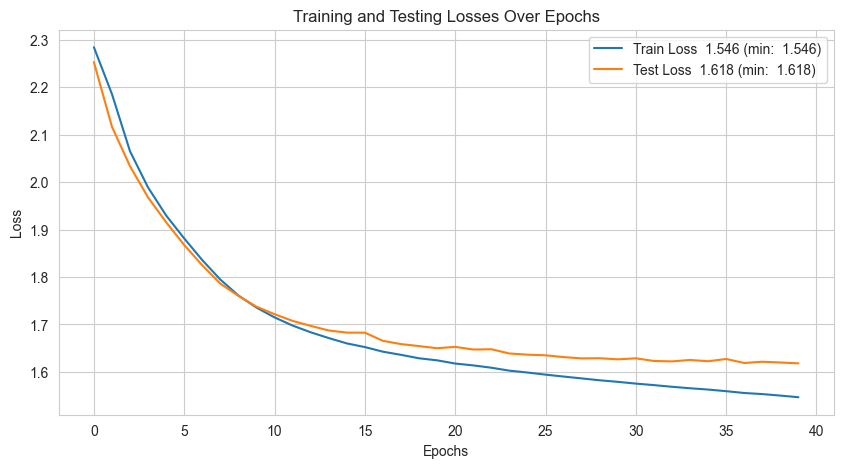

In [11]:
plot_losses(train_losses, val_losses, decimals=3)

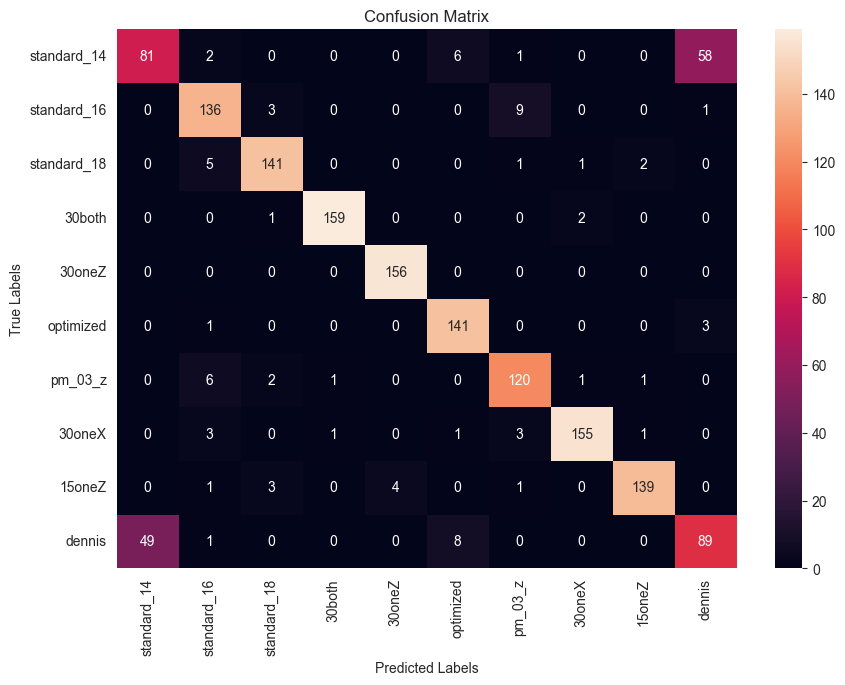

In [12]:
# predictions = model(X_torch.to(device))
# predictions
_, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.878


In [14]:
def criterion_correct(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    _, true_class_labels = torch.max(labels, 1)
    # print(predicted_labels)
    # print(y_torch)
    correct_predictions = torch.sum(predicted_labels == true_class_labels).item()
    return correct_predictions


correct_predictions, total = correct_number_test(model, test_loader, criterion_correct)
print(f"Number of correct predictions (test): {correct_predictions}/{total}")

correct_predictions, total = correct_number_test(model, val_loader, criterion_correct)
print(f"Number of correct predictions (val): {correct_predictions}/{total}")

Number of correct predictions (test): 1317/1500
Number of correct predictions (val): 1296/1500


Creating the least of the weights in 2D as a basis

In [15]:
def build_weights(weights, ls, ps, l1, l2, p1, p2):
    weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
    for l, p, weight in zip(ls, ps, weights):
        weights_ar[l - l1, p - p1] = weight
    return weights_ar

# getting the dimensions
filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
with open(filename, 'r') as file:
    reader = csv.reader(file)
    row = next(iter(reader))
    data_list = json.loads(row[0])
    # Convert the list back to a NumPy array if needed
    # print(data_list)
    # data_array = np.array(data_list)
    data_array = data_list

    l1, l2 = data_array[0], data_array[1]
    p1, p2 = data_array[2], data_array[3]
print(l1, l2, p1, p2)

values_basis = []
for knot in knots:
# for knot in ['6foil']:
    print(knot)
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:

        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        values = build_weights(weights, ls, ps, l1, l2, p1, p2)
        values = values / np.sqrt(np.sum(np.abs(values) ** 2))
        values_basis.append(values)
        # plt.imshow(np.abs(values).T[::-1])
        # plt.colorbar()
        # plt.show()

print(len(values_basis), values_basis[0].shape)

FileNotFoundError: [Errno 2] No such file or directory: '..\\data_no_centers_32114\\data_standard_14_spectr.csv'

In [ ]:
# Function to calculate MSE
def calculate_mse(array1, array2):
    return ((np.abs(array1) - np.abs(array2)) ** 2).mean()

closest_basis_knots = []
true_labels = []
for knot in knots:
    closest_basis_knot = []
    true_label = []
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            true_label.append(knot_types[knot])
            data_array = json.loads(row[0])

            # indx = data_array[4]
            # field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            # plt.imshow(np.abs(field ))
            # plt.show()

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            mse_scores = [calculate_mse(moments, values) for values in values_basis]
            closest_basis_knot.append(np.argmin(mse_scores))
            # plt.imshow(np.abs(moments))
            # plt.colorbar()
            # plt.show()
    true_labels.append(true_label)
    closest_basis_knots.append(closest_basis_knot)

# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:
predicted_labels_spec_np = np.array(closest_basis_knots).reshape(-1)
true_labels_spec_np = np.array(true_labels).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# def build_weights(weights, ls, ps, l1, l2, p1, p2):
#     weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
#     for l, p, weight in zip(ls, ps, weights):
#         weights_ar[l - l1, p - p1] = weight
#     return weights_ar
#
# # getting the dimensions
# filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
# with open(filename, 'r') as file:
#     reader = csv.reader(file)
#     row = next(iter(reader))
#     data_list = json.loads(row[0])
#     # Convert the list back to a NumPy array if needed
#     # print(data_list)
#     # data_array = np.array(data_list)
#     data_array = data_list
#
#     l1, l2 = data_array[0], data_array[1]
#     p1, p2 = data_array[2], data_array[3]
# print(l1, l2, p1, p2)

knots_basis = []
knots_basis_dots = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\data_basis\\data_{knot}.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]

            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            knots_basis_dots.append(points_list)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            knots_basis.append(dots_3d)

print(len(knots_basis), knots_basis[0].shape)
print(len(knots_basis_dots), knots_basis_dots[0].shape,knots_basis_dots[0][0])
print(knots_basis_dots[0].shape, knots_basis_dots[3].shape)

In [ ]:
# Function to calculate MSE
def calculate_mse_knot(array1, array2):
    return ((array1 - array2) ** 2).mean()

def calculate_mse_knot_dots(array1, dots):
    # loss = -np.sum([np.array(array1)[np.array(dot)] for dot in dots])
    loss = -np.sum([array1[tuple(dot)] for dot in dots])

    return loss

closest_knots = []
closest_knots_dots = []
true_knots = []
j = -1
for i, x in enumerate(X_torch):
    j += 1
    true_knots.append(torch.argmax(y_torch[i]).item())

    mse_scores = [calculate_mse_knot(x[0], knot_) for knot_ in knots_basis]
    closest_knots.append(np.argmin(mse_scores))

    mse_scores_dots = [calculate_mse_knot_dots(x[0], dots_) for dots_ in knots_basis_dots]
    # print(mse_scores_dots)
    # min_indices = np.where(mse_scores_dots == np.min(mse_scores_dots))[0]
    # if len(min_indices) > 1:
    #     result = 0
    # else:
    #     result = min_indices[0]
    closest_knots_dots.append(np.argmin(mse_scores_dots))
    # plt.imshow(knots_basis[j][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(x[0][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # break


# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:

predicted_labels_spec_np = np.array(closest_knots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

predicted_labels_spec_np = np.array(closest_knots_dots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:


X_list_sp = []
Y_list_sp = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:
        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        for row in reader:
                # Deserialize the JSON string back to a list
                data_list = json.loads(row[0])
                # Convert the list back to a NumPy array if needed
                # print(data_list)
                # data_array = np.array(data_list)
                data_array = data_list

                l1, l2 = data_array[0], data_array[1]
                p1, p2 = data_array[2], data_array[3]

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            # print(data_list)
            # data_array = np.array(data_list)
            data_array = data_list

            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]
            indx = data_array[4]
            field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            plt.imshow(np.abs(field ))
            plt.show()

            # print(f'l1, l2, p1, p2: {l1}, {l2}, {p1}, {p2} ({(l2 - l1 + 1) * (p2 - p1 + 1)})')
            # moments = np.array(data_array[4:]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            # plt.imshow(np.abs(moments).T[::-1, :])
            # plt.show()
            values = build_weights(weights, ls, ps, l1, l2, p1, p2)
            print(f"{knot}")
            plt.imshow(np.abs(values))
            plt.colorbar()
            plt.show()
            plt.imshow(np.abs(moments))
            plt.colorbar()
            plt.show()
            # plt.imshow(np.real(moments).T[::-1, :])
            # plt.show()
            print(moments)
            break
            # continue
            # points_list = data_array[2:]
            # Nx, Ny, Nz = data_array[1]
            # if desired_res != (Nx, Ny, Nz):
            #     scale_x = desired_res[0] / Nx
            #     scale_y = desired_res[1] / Ny
            #     scale_z = desired_res[2] / Nz
            #     points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # # Initialize a 3D array with zeros
            # dots_3d = np.zeros(desired_res, dtype=int)
            # # Set the specified coordinates to 1
            # for x, y, z in points_list:
            #     try: dots_3d[x, y, z] = 1
            #     except IndexError: continue
            # X_list.append(dots_3d)
            # # X_list.append(data_array)
            # Y_list.append(knot_types[knot])
    break

In [ ]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
# X_torch = torch.tensor(X_np).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)